In [1]:
from itertools import starmap, product
from math import log, exp
from pathlib import Path
from random import gauss
from typing import NoReturn

import matplotlib.pyplot as plt

from utils.X import X
from utils.algebra import Vector, vector, Scalar, mult_mv, diff_vv, sum_vv, mult_vs
from utils.data_utils import load, split2
from utils.model import Model
from utils.stop_conditions import StopConditions


In [2]:
def compute_error(pred: Vector, y: Vector) -> float:
    assert len(pred) == len(y)
    same = sum(starmap(lambda a, b: a == b, zip(pred, y)))
    return 1. - (float(same) / len(y))


In [3]:
class NaiveBayes(Model):
    def __init__(self, nfeatures: int, domain_size: int):
        self._domain_size, self._nfeatures = domain_size, nfeatures
        self._py = 0.
        self._pi = [[[0.] * self._domain_size for _ in range(self._nfeatures)],
                    [[0.] * self._domain_size for _ in range(self._nfeatures)]]

    def train(self, x: X, y: Vector) -> NoReturn:
        assert x.nfeatures() == self._nfeatures

        m = len(y)
        ones = sum(y)
        zeros = m - ones

        self._py = (1. + ones) / (m + 2.)

        counters = [[[0] * self._domain_size for _ in range(self._nfeatures)],
                    [[0] * self._domain_size for _ in range(self._nfeatures)]]

        for xi, yi in zip(x.by_sample(), y):
            for j, xij in enumerate(xi):
                counters[yi][j][xij] += 1

        for y_val, feature, k in product([0, 1], range(self._nfeatures), range(self._domain_size)):
            denominator = self._domain_size + y_val * ones + (1 - y_val) * zeros
            self._pi[y_val][feature][k] = (1 + counters[y_val][feature][k]) / denominator

    def _predict_one(self, x: Vector) -> Scalar:
        assert len(x) == self._nfeatures
        p0 = log(1. - self._py) + self._likelihood(x, 0)
        p1 = log(self._py) + self._likelihood(x, 1)
        return 0 if p0 >= p1 else 1

    def _likelihood(self, x: Vector, y_val: Scalar):
        assert y_val in [0, 1]
        return sum(map(lambda k: log(self._pi[y_val][k][x[k]]), range(len(x))))


In [4]:
STDEV = 1.
STOP_CONDITION = StopConditions(0.000001, None, 2000)
GRADIENT_STEP = 0.0001


class LogisticRegression(Model):
    def __init__(self):
        self._theta = None

    def train(self, x: X, y: Vector) -> NoReturn:
        x = x.append_ones()

        theta = vector(map(lambda _: gauss(0., STDEV), range(x.nfeatures())))

        stop_condition, stop = STOP_CONDITION, False
        while not stop:
            prediction = self._compute_prob(x, theta)
            diff = diff_vv(y, prediction)
            gradient = mult_mv(x.by_feature(), diff)

            theta = sum_vv(theta, mult_vs(gradient, GRADIENT_STEP))
            error = compute_error(self._decide(prediction), y)

            stop_condition, stop = stop_condition.update(gradient, error)
            # print(error)
        self._theta = theta

    @staticmethod
    def _compute_prob(x: X, theta: Vector) -> Vector:
        multiplied = mult_mv(x.by_sample(), theta)
        return vector(map(lambda m: 1. / (1. + exp(-m)), multiplied))

    @staticmethod
    def _decide(ps: Vector) -> Vector:
        return vector(map(lambda p: 0 if p <= 0.5 else 1, ps))

    def predict(self, x: X) -> Vector:
        assert self._theta is not None, "Model not trained yet"
        x = x.append_ones()
        prob = self._compute_prob(x, self._theta)
        return self._decide(prob)


In [5]:
x, y = load(Path('breast-cancer.data'))
x = vector(map(lambda xi: vector(map(lambda xij: xij - 1, xi)), x))
y = vector(map(lambda r: 0 if r == 2 else 1, y))

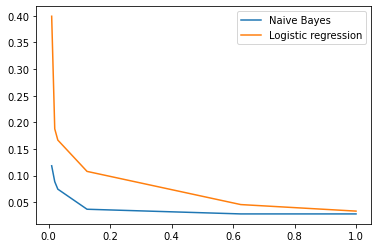

In [6]:
REPETITION = 5
train_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

bayes_cum_errors = [0. for _ in train_fractions]
logistic_cum_errors = [0. for _ in train_fractions]

for _ in range(REPETITION):
    (x_train, y_train), (x_test, y_test) = split2(x, y, 2 / 3)
    x_test = X(x_test)

    m = len(x_train)
    for i, tf in enumerate(train_fractions):
        avail_x_train, avail_y_train = X(x_train[:int(tf * m)]), y_train[:int(tf * m)]

        bayes = NaiveBayes(9, 10)
        bayes.train(avail_x_train, avail_y_train)
        bayes_cum_errors[i] += compute_error(bayes.predict(x_test), y_test)

        lr = LogisticRegression()
        lr.train(avail_x_train, avail_y_train)
        logistic_cum_errors[i] += compute_error(lr.predict(x_test), y_test)

bayes_cum_errors = list(map(lambda e: e / REPETITION, bayes_cum_errors))
logistic_cum_errors = list(map(lambda e: e / REPETITION, logistic_cum_errors))

plt.plot(train_fractions, bayes_cum_errors, label='Naive Bayes')
plt.plot(train_fractions, logistic_cum_errors, label='Logistic regression')
plt.legend()
plt.show()